# <strong> Language as a Cognitive Tool to Imagine Goals in Curiosity Driven Exploration </strong>

--------------------------------------------------------------------------------


Here add general introduction blog-post like with motivations, and illustrate with the schema that shows all modules.

Configuring everything:

In [1]:
%%capture

import numpy as np
import torch
import random
import pygame
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
from IPython.display import HTML

from src.imagine.experiment import config
from src.imagine.goal_sampler import GoalSampler
from src.utils.notebook_utils import get_params_for_notebook, get_modules_for_notebook

path= 'pretrained_weights/'
params = get_params_for_notebook(path)
policy_language_model, reward_language_model, policy, reward_function, goal_sampler = get_modules_for_notebook(path, params)

!!! TODO add packages to yml

## 1. IMAGINE under the hood

------------------------------------------------

### 1.1 The Social Partner Module





#### 1.1.1 First Role of the Social Partner: Setting up the scene

-----------

The first role of the Social Partner is to set up the scene so that the goal targeted by the agent can be achieved.

It provides the agent with optimal learning opportunities by organizing the scene with:
1. The required objects to reach the goal (not too difficult)
2. Procedurally-generated distracting objects (not too easy and providing further discovery opportunities)

The following lines of code show how scenes are generated according to this assumption:

In [2]:
# Enter a valid goal description
goal_str = 'Grasp blue lion'
if goal_str not in (params['train_descriptions'] + params['test_descriptions']):
    print('Please enter a feasible goal description.')

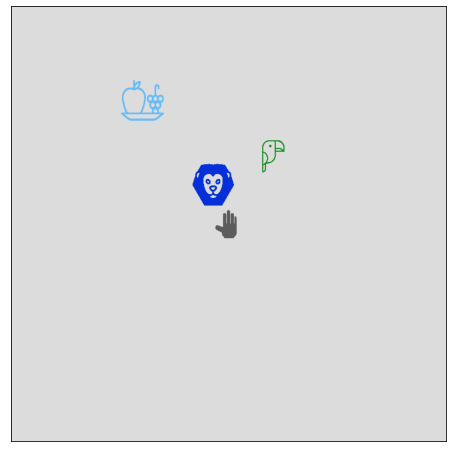

In [3]:
# Generating a scene which is compatible with the goal description
env = params['make_env']()
env.reset()
initial_o = env.unwrapped.reset_with_goal(goal_str)
env.step(np.array([0, 0, 0]))
env.render(close=True)
obs = pygame.surfarray.array3d(env.viewer).transpose([1,0,2])
# pygame.display.quit()
# pygame.quit()


plt.rcParams['figure.figsize'] = [12, 8]
fig = plt.imshow(obs)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

#### 1.1.2 Second Role of the Social Partner: Providing Descriptions

----------

Now talk about the different types of feedbacks, add the option, then run a trajectory and show the resulting set of descriptions.

In [4]:
%%capture
# In order to build vizualization
fig = plt.figure()
ims = []

## Rollout of a policy
o = initial_o.copy()
goal_encoding = policy_language_model.encode(goal_str)
episode={'obs':[]}
for t in range(30):
    action = policy.get_actions(o, goal_encoding)
    o,_,_,_ = env.step(action)
    episode['obs'].append(o)
    env.render(close=True)
    obs = pygame.surfarray.array3d(env.viewer).transpose([1,0,2])
    plt.rcParams['figure.figsize'] = [12, 8]
    im = plt.imshow(obs, animated=True)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=400, blit=False,
                                repeat=False)

In [5]:
HTML(ani.to_html5_video())

In [9]:
from src.imagine.social_partner import SocialPartner
oracle_reward_function = config.get_oracle_reward_function(goal_sampler, params)
social_partner = SocialPartner(oracle_reward_function=oracle_reward_function,
                                   feedback_strategy='exhaustive', p_availability=1.,
                                   params=params)

exhaustive_feedback = pd.DataFrame(social_partner.get_feedback([episode])[0][0], columns=['Descriptive Feedback from Social Partner'])
exhaustive_feedback

,Descriptive Feedback from Social Partner
0,Go left
1,Go top
2,Go center
3,Grasp blue living_thing
4,Grasp blue lion
5,Grasp any blue thing
6,Grasp any living_thing
7,Grasp any lion


In [10]:
# Fix this the social partner has no switch between one_pos_one_neg and exhaustive

social_partner2 = SocialPartner(oracle_reward_function=oracle_reward_function,
                                   feedback_strategy='one_pos_one_neg', p_availability=1.,
                                   params=params)

one_pos_one_neg_feedback = pd.DataFrame(social_partner2.get_feedback([episode])[0][0], columns=['Descriptive Feedback from Social Partner'])
one_pos_one_neg_feedback

,Descriptive Feedback from Social Partner
0,Go left
1,Go top
2,Go center
3,Grasp blue living_thing
4,Grasp blue lion
5,Grasp any blue thing
6,Grasp any living_thing
7,Grasp any lion


### 1.2 The Reward Function Module

<img src="https://drive.google.com/uc?export=view&id=1-74Gx9PkoPz4DC2gNPkdlSDeQsRVCq5G" alt="drawing" width="700"/>


Explain inference of reward function

Draw a goal description and a scene fulfilling this goal description. Maybe plot the evolution of the probability for each object as a function of time, and the overall probability in black.

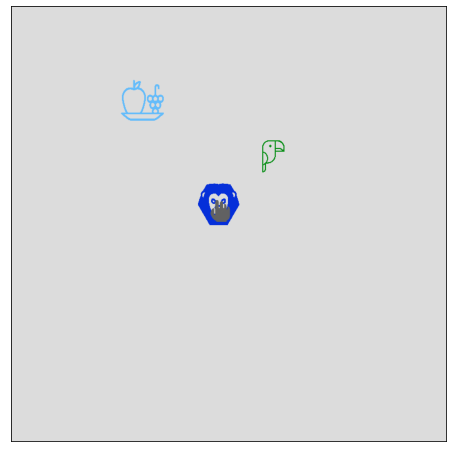

In [11]:
fig = plt.imshow(obs)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [12]:
def compute_reward_probabilities(state, goal_str, reward_language_model, reward_function, env):
    goal_encoding = reward_language_model.encode(goal_str)
    input_o = torch.tensor(state).float().view(1,len(o))
    input_goal = torch.tensor(goal_encoding).float().view(1,len(goal_encoding))
    reward_per_object = reward_function.reward_function.compute_logits_before_or(input_o, input_goal)
    reward_per_object = [elem.detach()[0][0].item() for elem in reward_per_object]
    objects = [obj.object_descr['colors'] + ' ' + obj.object_descr['types'] for obj in env.objects]
    d = {'Objects':objects, 'Reward':reward_per_object}
    df_rew = pd.DataFrame(d)
    return df_rew

def generate_other_possible_goal(goal_str, env):
    objects = [obj.object_descr['colors'] + ' ' + obj.object_descr['types'] for obj in env.objects]
    other_objects = [o for o in objects if o not in goal_str]
    return ' '.join(random.sample(['Grow', 'Grasp'], 1) + random.sample(other_objects, 1))

In [20]:
other_goal_str = generate_other_possible_goal(goal_str,env)
print(other_goal_str)

Grow green parrot



Explain that we scan the reward per object for:

1. the achieved goal
2. another feasible goal considering the scene which is not achieved

Discuss the probabilities



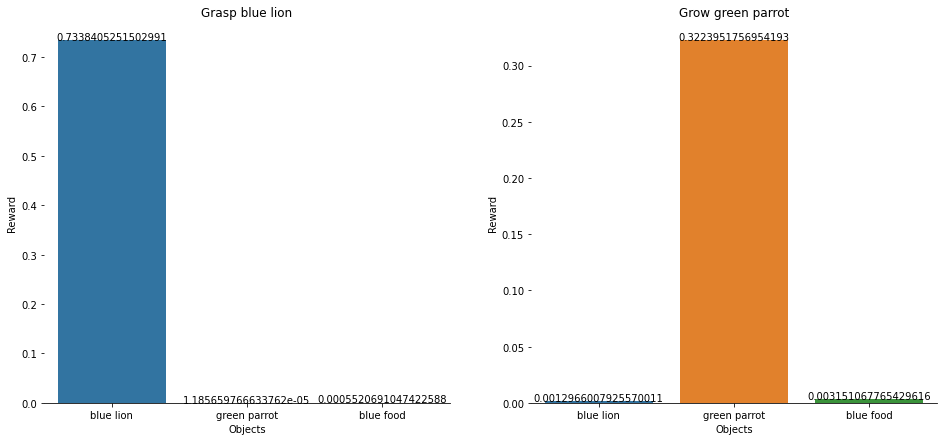

In [19]:
df_rew1 = compute_reward_probabilities(o, goal_str, reward_language_model, reward_function, env)
df_rew2 = compute_reward_probabilities(o, other_goal_str, reward_language_model, reward_function, env)

f, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)
sns.despine(left=True)
sns.barplot(x="Objects", y="Reward", data=df_rew1, ax=axes[0]).set_title(goal_str)
for index, row in df_rew1.iterrows():
    axes[0].text(row.name,row.Reward, row.Reward, color='black', ha="center")
    
sns.despine(left=True)
sns.barplot(x="Objects", y="Reward", data=df_rew2, ax=axes[1]).set_title(other_goal_str)
for index, row in df_rew2.iterrows():
    axes[1].text(row.name,row.Reward, row.Reward, color='black', ha="center")


Explain intuition behind reward function architecture

In [36]:
float("{:.2f}".format(13.949999999999999))

13.95

In [20]:
torch.tensor(o).view([1,len(o)]).shape

torch.Size([1, 240])

In [3]:
# Load a pretrained reward function
# Use reward function in inference
# Show results of reward function before or (object specific rewards)
# Show results of reward function 

### 1.3 The Policy Module

Dunno yet what we can show here. Maybe just a run towards a goal, and maybe the evolution of the norm of the signal before the deepset aggregation (showing the norm of the module handling the relevant object is higher).


In [ ]:
# Dunno yet what we can show here. Maybe just a run towards a goal, and maybe the evolution of the norm of the signal before the deepset aggregation (showing the norm of the module handling the objects )

### 1.4 The Goal Imagination Module

In [ ]:
# Show the set of imagined goal generated from a subset of known goals

## 2. How to train IMAGINE

------------

In [ ]:
# Insert train script here

## 3. Examples of Generalization

In [ ]:
# Enter goal here

In [ ]:
# Load pretrained model and generate rollout here

## 4.  Vizualization

In [ ]:
# Insert cool vizualization of attention vectors here

In [ ]:
# Insert interactive viz of t-sne goals here